<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 40px;'>🚀</span>
  <span style='font-weight: normal; font-size: 32px; color: #3AB77A;'>Desafio Creditas -</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'> Cientista de Dados Pleno</span>
</div>
<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-weight: normal; font-size: 19px; color: #F;'>Etapa 7: Calculo dos ganhos do modelo</span>
</div>

<br><br>

<div style='color: #3AB77A; text-align: center; font-size: 28px; font-weight: bold'>
  <p>
    Conteúdo desse Notebook
  </p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Calculando o desempenho e escolhendo o melhor corte para o modelo</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Analise dos resultados do modelo em relação ao KPI de horas</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Comparação com metodologia atual do Dummy Classifier</p>
</div>


In [1]:
import pandas as pd
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath(".."))

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split        
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from utils.plot_utils import plotter as ptz

pd.set_option('display.max_columns', 500)
from utils.eda_utils import (
    get_all_information,
    StartEda
)

from utils.feature_utils import (
    ModelUtils,
)

from utils.model_utils import (
    score_interval_evaluation,
    plot_confusion_matrix,
    plot_precision_recall_and_roc,
    calculate_gains
)

import warnings
warnings.filterwarnings("ignore")

# Dessa vez utilizando a base bronze
df = pd.read_csv('../data/bronze_dataset.csv')
get_all_information(df=df, column_filter='pre_approved', column_target='sent_to_analysis')
df = df[df['pre_approved'] == 1].drop(['pre_approved'],axis=1)

# Realizando os processos de input de NA baseado na regra identificada anteriormente
control = StartEda(df=df, direct_input_cols=['collateral_debt','informed_restriction'])
df = control.df

df.drop([
    'city',
    'auto_model',
    'informed_purpose'
],axis=1,inplace=True)

import yaml
with open('../utils/variables.yml', 'r') as file:
    variables = yaml.safe_load(file)

import pickle
with open('../models/rs_model_primeira_versao.pkl', 'rb') as file:
    model = pickle.load(file)

# Analisando a problematica dos dados #
De todos os casos nessa base, reprovados temos 19820
De todos os casos nessa base, pré-aprovado temos 14976
Que realmente aprovamos para a analise de crédito foram 3262
Que realmente reprovamos para a analise de crédito foram 11714


In [2]:
columns_ignore= [
 'dishonored_checks','expired_debts','banking_debts','commercial_debts','protests','informed_restriction','form_completed','verified_restriction'
]

columns_without = [
 'dishonored_checks','expired_debts','banking_debts','commercial_debts','protests','informed_restriction','form_completed','verified_restriction',
]

education_order = [
'Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.',
'Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.',
'4ª série completa do ensino fundamental (antigo 1º grau ou primário).',
'Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).',
'Ensino fundamental completo (antigo 1º grau ou primário e ginasial).',
'Ensino médio incompleto (antigo 2º grau, secundário ou colegial).',
'Ensino médio completo (antigo 2º grau, secundário ou colegial).',
'Educação superior incompleta.',
'Educação superior completa'
]

model_prep = ModelUtils(
    df=df,
    target='sent_to_analysis',
    columns_ignore=columns_ignore,
    columns_without=columns_without
)

X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = model_prep.start_pipeline()

X_train_transformed = X_train_transformed[variables['columns_keepers']]
X_val_transformed = X_val_transformed[variables['columns_keepers']]
X_test_transformed = X_test_transformed[variables['columns_keepers']]

for col in [
    'banking_debts', 
    'informed_restriction', 
    'form_completed', 
    'verified_restriction'
]:
    X_train_transformed[col] = X_train_transformed[col].astype('int64')
    X_val_transformed[col] = X_val_transformed[col].astype('int64')
    X_test_transformed[col] = X_test_transformed[col].astype('int64')

model_prep.pipe_prep[0]

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'form_completed', 'verified_restriction']
['id', 'age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'IdadeCarro', 'isSP', 'QtdSalariosMinimos', 'ValorGarantiaRealAuto', 'PropLoanGarantiaVeiculo', 'PropLoanReal', 'PropLoanMonthlyIncome', 'numero_de_empresas_atuantes', 'PropIncomeSalarioMedioMensal', 'ClassPurpose']
['channel', 'landing_page_product', 'gender', 'education_level', 'ClassMarca', 'regiao']
DataFrames criados sendo numericas:17, one_hot:6, ordinal:0
Pipelines criados, criando of FeatureUnion
[FeatureUnion] ...... (step 1 of 3) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 2 of 3) Processing pipe_hot, total=   0.0s
[FeatureUnion]  (step 3 of 3) Processing pipe_sem_mexer, total=   0.0s
18270.0 0.0 23000.0 24999.0
10.506162830680966 0.0 10.7

FeatureUnion(transformer_list=[('pipe_num',
                                Pipeline(steps=[('selector_numerical',
                                                 ColumnTransformer(transformers=[('filter_num_cols',
                                                                                  'passthrough',
                                                                                  array(['id', 'age', 'monthly_income', 'collateral_value', 'loan_amount',
       'collateral_debt', 'monthly_payment', 'IdadeCarro', 'isSP',
       'QtdSalariosMinimos', 'ValorGarantiaRealAuto',
       'PropLoanGarantiaVeiculo', 'PropLoan...
                                                 SimpleImputer(strategy='most_frequent')),
                                                ('OneHotEncoder', None)])),
                               ('pipe_sem_mexer',
                                Pipeline(steps=[('selector_one_hot',
                                                 ColumnTransformer(transformers=[('filter_ignore_cols',
                                                                                  'passthrough',
                                                                                  array(['dishonored_checks', 'expired_debts', 'banking_debts',
       'commercial_debts', 'protests', 'informed_restriction',
       'form_completed', 'verified_restriction'], dtype=object))]))]))],
             verbose=True)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Results: Analisando os cortes do modelo</span>
</div>

<br>

In [3]:
y_pred = model.predict_proba(X_val_transformed)[:,1]
y_val.name = 'status_final_model'
score_interval_evaluation(
    target=y_val,
    predicted_probabilities=y_pred, 
    X_val=X_val_transformed,
    y_val=y_val
)

Index(['target'], dtype='object')


,score_interval,volumetria,acertos,volumetria_acc,acertos_acc,erros,erros_acc,prec_linha,recall_linha,percent_impact,percent_error,percent_acertos,prec_acc,recall_acc
20,"(0.95,1.00]",0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,"(0.90,0.95]",0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,"(0.85,0.90]",0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,"(0.80,0.85]",65,36.0,65.0,36.0,29.0,29.0,0.573184,0.026417,2.169559,1.237729,5.513017,0.553846,0.055130
16,"(0.75,0.80]",168,91.0,233.0,127.0,77.0,106.0,0.568305,0.143338,7.777036,4.524114,19.448698,0.545064,0.194487
15,"(0.70,0.75]",96,45.0,329.0,172.0,51.0,157.0,0.524980,0.231547,10.981308,6.700811,26.339969,0.522796,0.263400
14,"(0.65,0.70]",80,39.0,409.0,211.0,41.0,198.0,0.518491,0.302910,13.651535,8.450704,32.312404,0.515892,0.323124
13,"(0.60,0.65]",328,127.0,737.0,338.0,201.0,399.0,0.481317,0.455436,24.599466,17.029449,51.761103,0.458616,0.517611
12,"(0.55,0.60]",236,73.0,973.0,411.0,163.0,562.0,0.434007,0.579786,32.476636,23.986342,62.940276,0.422405,0.629403
11,"(0.50,0.55]",201,38.0,1174.0,449.0,163.0,725.0,0.396414,0.665850,39.185581,30.943235,68.759571,0.382453,0.687596


In [4]:
y_pred = model.predict_proba(X_val_transformed)[:, 1]
threshold = 0.65
y_label_val = (y_pred >= threshold).astype(int)
print(classification_report(y_true=y_val, y_pred=y_label_val))

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      2343
         1.0       0.50      0.38      0.43       653

    accuracy                           0.78      2996
   macro avg       0.67      0.64      0.65      2996
weighted avg       0.76      0.78      0.77      2996



In [5]:
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
y_label_test = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_true=y_test, y_pred=y_label_test))

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      2343
         1.0       0.53      0.42      0.47       652

    accuracy                           0.79      2995
   macro avg       0.69      0.66      0.67      2995
weighted avg       0.78      0.79      0.78      2995



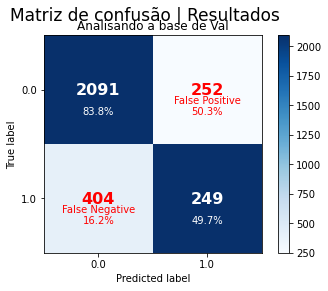

In [6]:
plot_confusion_matrix(
    y_true=y_val, 
    y_pred=y_label_val, 
    split='Val', 
    position_title=0.475
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Results: Modelo desafiante x Modelo Atual</span>
</div>

<br>

In [7]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

dummy_clf.fit(X_train_transformed, y_train)
y_pred_dummy = dummy_clf.predict(X_val_transformed)

print(classification_report(y_true=y_val, y_pred=y_pred_dummy))

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79      2343
         1.0       0.25      0.25      0.25       653

    accuracy                           0.67      2996
   macro avg       0.52      0.52      0.52      2996
weighted avg       0.67      0.67      0.67      2996



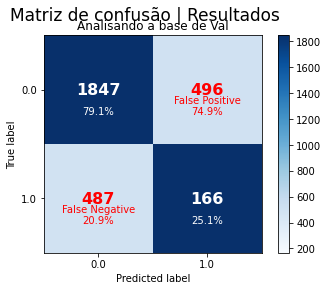

In [8]:
plot_confusion_matrix(
    y_true=y_val, 
    y_pred=y_pred_dummy, 
    split='Val', 
    position_title=0.475
)

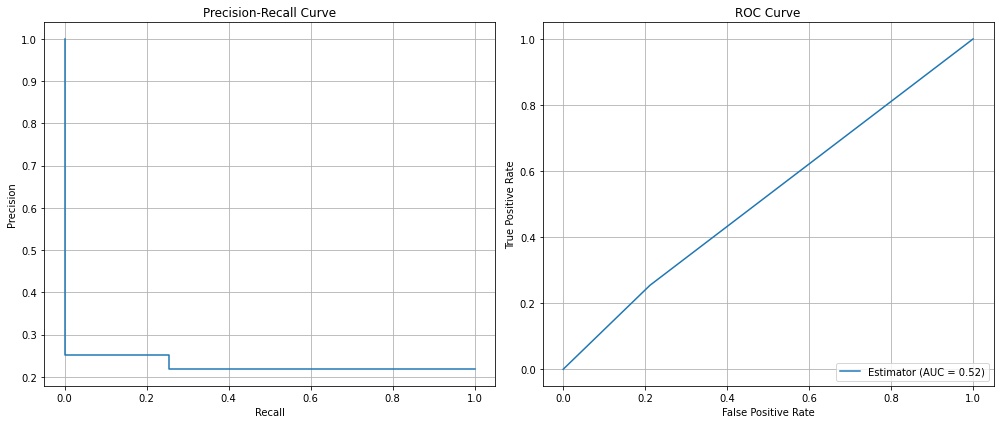

In [9]:
y_pred = dummy_clf.predict_proba(X_val_transformed)[:,1]
plot_precision_recall_and_roc(
    y_true=y_val, 
    y_pred=y_pred, 
    estimator_name="Estimator"
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Results: Conclusões</span>
</div>

<br>

In [10]:
# Modelo Desafiante

calculate_gains(
    df=X_val_transformed.copy(),
    target=y_val,
    predicted_label=y_label_val,
    time_spent_hours=120
)

###############
> O modelo conseguiu identificar casos em que não avançariam para a analise de crédito poupando 250920 horas de trabalho
> O modelo gerou uma quantidade de Falso Positivo gerando 30240 mais horas de trabalho
> O modelo conseguiu identificar casos em que avançariam para a analise de crédito em quantidade 249
###############


In [11]:
# Modelo Dummy

calculate_gains(
    df=X_val_transformed.copy(),
    target=y_val,
    predicted_label=y_pred_dummy,
    time_spent_hours=120
)

###############
> O modelo conseguiu identificar casos em que não avançariam para a analise de crédito poupando 221640 horas de trabalho
> O modelo gerou uma quantidade de Falso Positivo gerando 59520 mais horas de trabalho
> O modelo conseguiu identificar casos em que avançariam para a analise de crédito em quantidade 166
###############


![problem](../images/desempenho_modelo.PNG)

![problem](../images/monitoramento_model.PNG)